# Preprocessing steps to process raw CEST MRI data, and generation of truth values

The various preprocessing steps include normalization, B0 correction

Load Dependencies

In [35]:
# load libraries
from pylab import *
import cjlib,nylib,nylib2
from pydicom import dicomio
import nibabel as nib
import pandas as pd
import numpy as np
import scipy


from pybaselines.polynomial import poly
import pybaselines
from skimage.filters  import threshold_otsu
from skimage import measure
from skimage.morphology import disk

import skimage.morphology as morph
# # import image reading module image from matplotlib
import matplotlib.image as img
# #import image ploting module pyplot from matplotlib 
import matplotlib.pyplot as plt

%matplotlib inline


Utility functions

In [4]:
from scipy import optimize
from scipy.interpolate import pchip_interpolate

# define functions
def wassrProcessing(wassrFreq, wassrData, tubeMask):
   
    allS0 = np.where(wassrFreq >= 100*298)[0]
    if len(allS0) > 0:
        tagS0 = np.min(allS0)
#         print tagS0
        inds = np.argsort(wassrFreq[:tagS0])
        wassrFreq[:tagS0] = wassrFreq[:tagS0][inds]
        wassrData[:tagS0] = wassrData[:tagS0][inds]
        
    [cestB0Map, delta_freq_map] = getB0Map(wassrFreq, wassrData, tubeMask==True)

    return cestB0Map, delta_freq_map

def getB0Map(freq, data, mask):
    gyr = 42.58 *(10**6)
    B0map = np.zeros((data.shape[1],data.shape[2]))
    delta_freq_map = np.zeros((data.shape[1],data.shape[2]))

    
    fit_freq_range = np.where( (freq >= -298*2.) * (freq <= 298*2.) )
#     print (freq[fit_freq_range])
    freq_used_itp = np.linspace(min(freq[fit_freq_range]), max(freq[fit_freq_range]), num=50)

    for ii in range(data.shape[1]):
        for ij in range(data.shape[2]):
            if mask[ii, ij]==0:
                continue
            data2fit = 1 - data[:, ii, ij] / np.max(data[:, ii, ij])
            Zspectrum = data[:,ii, ij]
            ind = np.argmax(data2fit)
            intial_p1 = freq[ind]
            data2fit_itp = pchip_interpolate(freq[fit_freq_range], data2fit[fit_freq_range], freq_used_itp)
            para = lorentzfit(freq_used_itp, data2fit_itp, (1e3, intial_p1, 1e3, 0.1))
            delta_freq = para[1]
            delta_freq_map[ii, ij] = delta_freq

            B0map[ii,ij] = -para[1]/gyr
    return B0map, delta_freq_map

def lorentzfit(freqdata,Zspectrum,varargin):
	def lfun3c(p0,x):
		F = p0[0] / ((x-p0[1])**2 + p0[2]) + p0[3]
		return F

	def cestFit( freq, mm, p0):
		errfunc = lambda p, x, y: lfun3c(p, x) - y
		p1, success = optimize.leastsq(errfunc, p0[:], args=(freq, mm))
		return p1

	p0 = varargin
	fitParameters = cestFit( freqdata, Zspectrum, p0)
	return fitParameters


def normalizeData(freq, data, mask):

    allS0 = np.where(freq >= 100)[0]
    if len(allS0) == 1:
        tagS0 = allS0[0]
    elif len(allS0) > 1:
        tagS0 = np.min(allS0)
#     print stagS0
    
    norData = np.zeros((data.shape[0]-len(allS0), data.shape[1], data.shape[2]))
    for ii in range(norData.shape[1]):
        for ij in range(norData.shape[2]):
            if mask[ii, ij]==0:
                continue
                    # print data[di, tagS0:-1, ii, ij].shape
            S0 = np.mean(data[tagS0:, ii, ij], axis = 0)
            norData[:, ii, ij] = data[:tagS0, ii, ij]/S0 #contain PVM_ppgFreqList1
    return norData

def B0correct(data, mask, delta_freq_map, freq):
    
    gyr = 42.58 *(10**6)
    correctData = np.zeros((data.shape[0], data.shape[1], data.shape[2]))
    for ii in range(correctData.shape[1]):
        for ij in range(correctData.shape[2]):
            if mask[ii, ij]==0:
                continue
            correctData[:, ii, ij] = b0SignalCorr(freq, data[:,ii,ij], -1*delta_freq_map[ii, ij])
    return correctData

def b0SignalCorr(freq, zspectrum, b0):
    correctedSpectrum = np.zeros((len(freq)))
    for ii in range(correctedSpectrum.shape[0]):
#         freqIndex = find_nearest(freq, (freq[ii]+b0))[1]
        freqIndex = argmin((freq + b0 -freq[ii])**2)
        correctedSpectrum[ii] = zspectrum[freqIndex]
    return correctedSpectrum


In [5]:
from scipy import interpolate
import cv2
def freq_sort(MI_rare_temp, w_temp):    
    idx = w_temp.argsort()
    MI_rare = MI_rare_temp[:,:,idx]
    
    w = w_temp[idx]
    return MI_rare, w

def Zprocess_S_func(MI_rare, w, b0map, Thmask):
	# 7T
    FS=298.
    
    allS0 = np.where(w >= 100* FS)[0]
    tagS0 = np.min(allS0)
        
    # sw = arange(-5,5.1,0.1)
    sw = w[:tagS0]/ FS
    sw_H = FS*sw
    
    MI_rare_temp = MI_rare
    w_temp = w
    M0=mean(MI_rare[:,:,tagS0:],2)
    MI_rare, w = freq_sort(MI_rare_temp, w_temp)
    
    M,N,siw = MI_rare.shape
    
    Mz=zeros((MI_rare.shape[0],MI_rare.shape[1],MI_rare.shape[2]-len(allS0)))
    for k in range(len(w)-len(allS0)):
        temp = MI_rare[:,:,k]*Thmask
        # print (temp)
        Mz[:,:,k] = temp/M0
    
#     Mz = Mz[:,:,0:-3]/M0
    # print Mz.shape
    w = w[0:tagS0]
    
    MI=B0correction_Spline(Mz, w, sw_H, b0map, 1)
    
    return MI, sw

def B0correction_Spline(MI, w, wSp, B0map, Nma):
    M, N, siw = MI.shape
    b0map= zeros((M,N))
    newMI= zeros((M,N, len(wSp)))
    
    row, col = where(MI[:,:,0]>0)
    
    for ind in range(len(row)):
        m2 = squeeze (MI[row[ind],col[ind],:])
        m2 = m2.reshape(len(m2),1)
        # m = moving_average(m2, Nma)
        m = m2

#         print (row[ind])
#         print (col[ind])
        
        b0 = B0map[row[ind],col[ind]]
        if isnan(b0):
            mSp = zeros(m2.shape)
        else:
        	mSp = interpolate.pchip_interpolate(w-b0, m, wSp)
        	newMI[row[ind],col[ind],:] = squeeze(mSp)
            
    return newMI


In [6]:
import matplotlib.pyplot as plt
import IPython.display as Disp
from ipywidgets import widgets
import numpy as np
import cv2
from PIL import Image, ImageDraw

class bbox_select():
#     %matplotlib notebook 

    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy(),cmap='gray')
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)

    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),4)
        return img

    def onclick(self, event):
    #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)
        
def roipolyny_2(data, XY):
    XY_flat = np.array(XY).flatten().tolist()
    img = Image.new('L', (data.shape[-1], data.shape[-2]), 0)
    ImageDraw.Draw(img).polygon(XY_flat, outline=1, fill=1)
    mask = np.array(img)
    return mask

def create_mask(image):
    ps = bbox_select(image)
    mask = roipolyny_2(image, ps.selected_points)
    return mask

# read data

In [13]:
dataPath = '/mnt/yadav_lab_backup/vdsouza1/Human_data/std_20220608_114907663/'
dicom_file_prefix = 'std_20220608_114907663/'
scanTimes = array(["01_Survey",'07_MPRAGE_1mm','08_kirbyCEST_1uT', '09_T1LookLocker_edit2','10_kirbyCEST_1uT','06_B1_before_calib',])


In [14]:
scanName = [None for ii in range(len(scanTimes))]
Comments = [None for ii in range(len(scanTimes))]
expRunTime = [None for ii in range(len(scanTimes))]
expDescription = [None for ii in range(len(scanTimes))]


import datetime
for ii, si in enumerate(scanTimes):
    dataTemp = dicomio.read_file('%s/%s%s.dcm'%(dataPath, dicom_file_prefix, scanTimes[ii]), stop_before_pixels=True)
    scanName[ii] = dataTemp.SeriesDescription
    timeTemp = '%s%s'%(dataTemp.SeriesDate, dataTemp.SeriesTime[:6])
    timeTemp2 = datetime.datetime.strptime(timeTemp, '%Y%m%d%H%M%S')
    expRunTime[ii] = timeTemp2.strftime('%H:%M:%S') #downgrading date info

expTable = zip(scanName, expRunTime, expDescription, Comments)
df = pd.DataFrame(data = expTable, columns=['ScanName', 'expRunTime', 'expDescription', 'Comments'])

df['Comments'][31] = 'six averages'
# df['expDescription'][4] = '1.5 uT'
# df['expDescription'][9] = '2.0 uT'
# df['Comments'][3] = 'axial'
# df['Comments'][4] = 'coronal'

df['expRunTime'] = (pd.to_datetime(df['expRunTime']))
df['expRunTime'] = df['expRunTime'].dt.time
df.sort_values(by=['expRunTime'])

,ScanName,expRunTime,expDescription,Comments
0,Survey,11:10:53,None,None
5,B1_before_calib,11:19:06,None,None
1,MPRAGE_1mm,11:19:56,None,None
2,kirbyCEST_1uT,11:23:22,None,None
3,T1LookLocker_edit2,11:36:07,None,None
4,kirbyCEST_1uT,11:40:20,None,None


(9, 256, 256)

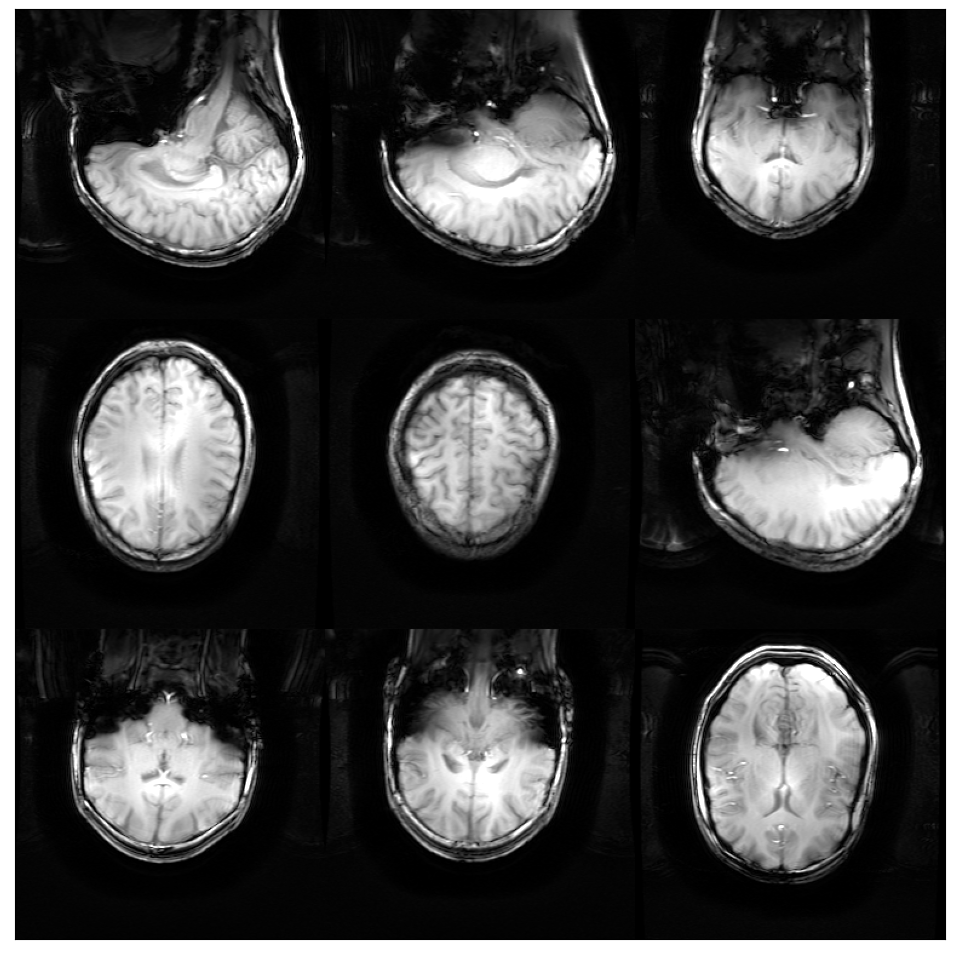

In [15]:
%matplotlib inline

survey_data = (dicomio.read_file('%s/%s%s.dcm'%(dataPath, dicom_file_prefix, scanTimes[0]))).pixel_array

figure(figsize=(12,16))
cjlib.mmontageNEW(survey_data, (3,3))
savefig('test.pdf', dpi=300)
survey_data.shape


# CEST example

In [16]:
cestFreq = r_[0, 
              80000, 4470, 2980, 2086, 1490, 1341, 1192,
              80001, 1043, 894, 745, 596, 566, 536, 
              80002, 507, 477, 447, 417, 387, 358, 
              80003, 328, 298, 268, 238, 209, 179,
              80004,  149, 119, 89, 60, 30, 0,
              80005, -30, -60, -89, -119, -149, -179,
              80006, -209, -238, -268, -298, -328, -358,
              80007, -387, -417, -447, -477, -507, -536,
              80008, -566, -596, -745, -894, -1043, -1192,
              80009, -1341, -1490, 80010] / 298.

cestFreq = cestFreq[1:]
cestFreq.shape


(67,)

In [17]:
cestData_cov_eg = (dicomio.read_file('%s/%s%s.dcm'%(dataPath, dicom_file_prefix, scanTimes[2]))).pixel_array
print(cestData_cov_eg.shape)
cestData_cov_eg = reshape(cestData_cov_eg, (68,30,cestData_cov_eg.shape[-2],cestData_cov_eg.shape[-1]))
cestData_cov_eg.shape

(2040, 192, 192)


(68, 30, 192, 192)

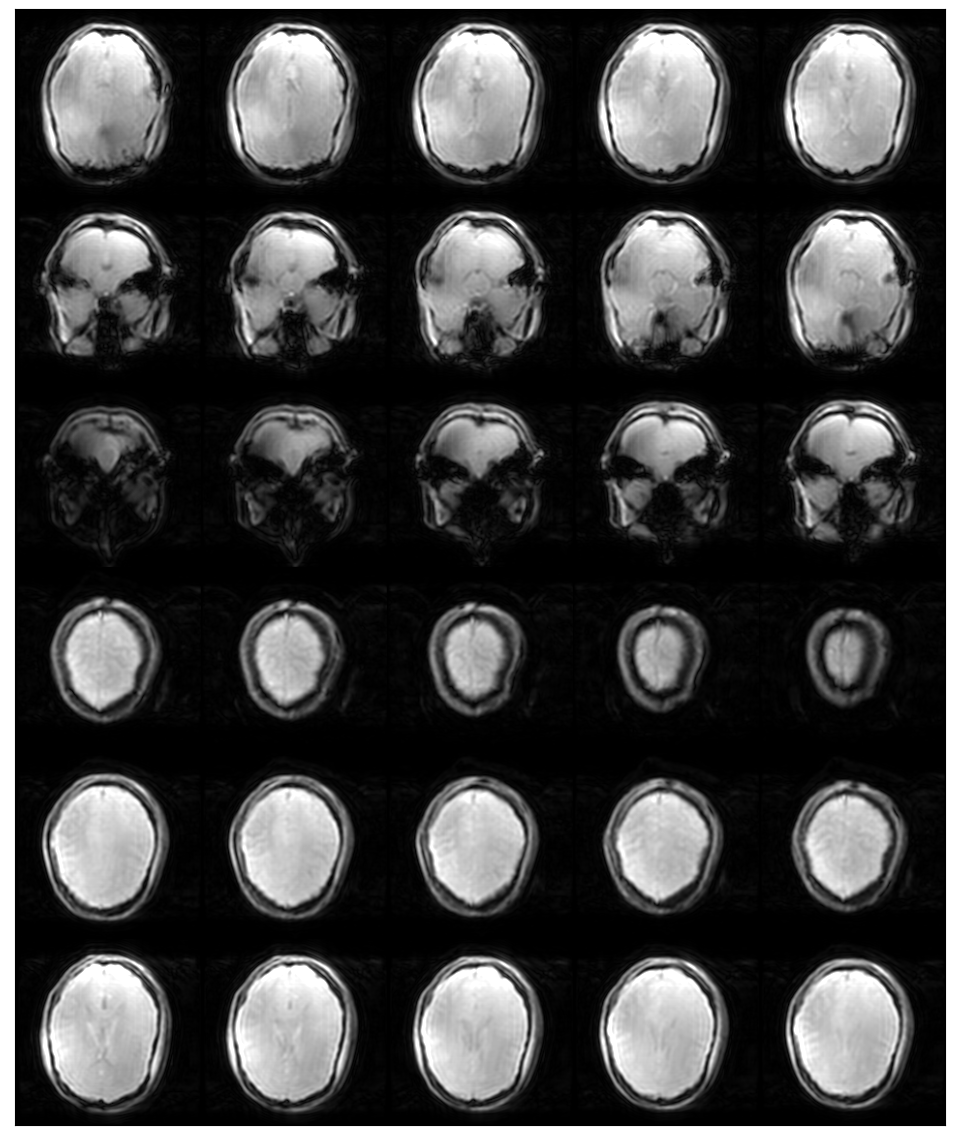

In [18]:
figure(figsize=(12,16))
cjlib.mmontage(cestData_cov_eg[0])


In [19]:
# get mask
mask_slices = np.zeros((cestData_cov_eg.shape[1],cestData_cov_eg.shape[-2],cestData_cov_eg.shape[-1]))

for kk in range(mask_slices.shape[0]):
    data_test = cestData_cov_eg[0,kk]
    inim=data_test
    dimn=inim.shape

    th=threshold_otsu(inim)
    binim1=inim>th
    eroded_image=morph.erosion(binim1,disk(4))
    labelimg=measure.label(eroded_image,background=0)
    prop=measure.regionprops(labelimg)
    ncount=len(prop)

    argmax=0
    maxarea=0
    #Find the largets connected region
    for i in range(ncount):
        if(prop[i].area >maxarea):
            maxarea=prop[i].area
            argmax=i

    bmask=np.zeros(inim.shape,dtype=np.uint8)
    bmask[labelimg == (argmax+1)] =1
    mask_slices[kk]=bmask


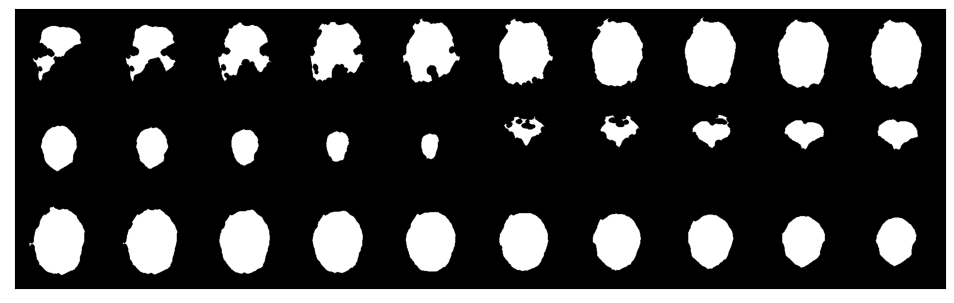

In [20]:
figure(figsize=(12,16))
cjlib.mmontageNEW(mask_slices, (3,10))



In [22]:
dict_freq = {'cest_freq':cestFreq}
dict_freq_df = pd.DataFrame(dict_freq)
dict_freq_df.to_csv('/mnt/yadav_lab_backup/vdsouza1/Human_data/cest_freq.csv',index=False)
cestFreq_sim_2 = pd.read_csv('/mnt/yadav_lab_backup/vdsouza1/Human_data/cest_freq.csv')
cestFreq_sim_2 = cestFreq_sim_2['cest_freq']
cestFreq_sim_2.shape

(67,)

In [23]:
# load cest data, remove 1st dynamic scan
cest_scans=r_[2]

cestData_cov = zeros((len(cest_scans),len(cestFreq),cestData_cov_eg.shape[1],cestData_cov_eg.shape[2],cestData_cov_eg.shape[2]))
for ii in range(cest_scans.shape[0]):
    temp = (dicomio.read_file('%s/%s%s.dcm'%(dataPath, dicom_file_prefix, scanTimes[int(cest_scans[ii])]))).pixel_array
    temp = reshape(temp, (68,30,cestData_cov_eg.shape[-2],cestData_cov_eg.shape[-1]))
    temp = temp[1:]
    cestData_cov[ii] = temp

In [24]:
# after sorting, last 11 scan are S0
sort_inds = cestFreq.argsort()
cestFreq_sort = cestFreq[sort_inds]
print (sort_inds)

cestData_cov_sort = cestData_cov[:,sort_inds]

print (cestData_cov_sort.shape)


[65 64 62 61 60 59 58 57 55 54 53 52 51 50 48 47 46 45 44 43 41 40 39 38
 37 36 34 33 32 31 30 29 27 26 25 24 23 22 20 19 18 17 16 15 13 12 11 10
  9  8  6  5  4  3  2  1  0  7 14 21 28 35 42 49 56 63 66]
(1, 67, 30, 192, 192)


In [25]:
cestData_cov_sort_new = zeros(cestData_cov_sort.shape)
cestData_cov_new = zeros(cestData_cov.shape)

from scipy.interpolate import splev, splrep

x = linspace(0,12,11)
for ii in range(cestData_cov_sort.shape[0]):
    for jj in range(cestData_cov_sort.shape[2]):
        for mm in range(mask_slices[jj].shape[0]):
            for nn in range(mask_slices[jj].shape[1]):
                if mask_slices[jj,mm,nn]==1:     
                    y = cestData_cov_sort[ii,56:,jj,mm,nn]/cestData_cov_sort[ii,56,jj,mm,nn]
                    spl = splrep(x, y)
                    x2 = np.linspace(0, 12, 67)
                    y2 = splev(x2, spl)
                    y3 = cestData_cov[ii,:,jj,mm,nn]/cestData_cov[ii,0,jj,mm,nn]
                    cestData_cov_new[ii,:,jj,mm,nn] = y3/y2
#                     print (cestData_cov_new[ii,:,jj,mm,nn])

In [26]:
# after sorting, last 11 scan are S0
sort_inds = cestFreq.argsort()
cestFreq_sort = cestFreq[sort_inds]
print (sort_inds)

cestData_cov_sort_new = cestData_cov_new[:,sort_inds]

print (cestData_cov_sort_new.shape)


[65 64 62 61 60 59 58 57 55 54 53 52 51 50 48 47 46 45 44 43 41 40 39 38
 37 36 34 33 32 31 30 29 27 26 25 24 23 22 20 19 18 17 16 15 13 12 11 10
  9  8  6  5  4  3  2  1  0  7 14 21 28 35 42 49 56 63 66]
(1, 67, 30, 192, 192)


In [27]:
# B0 shift

wassr_Map = zeros((cestData_cov_sort_new.shape[0],cestData_cov_sort_new.shape[2],cestData_cov_sort_new.shape[-2],cestData_cov_sort_new.shape[-1]))
delta_freq_map = zeros((cestData_cov_sort_new.shape[0],cestData_cov_sort_new.shape[2],cestData_cov_sort_new.shape[-2],cestData_cov_sort_new.shape[-1]))

for ii in range(cestData_cov_sort_new.shape[0]):
    for jj in range(cestData_cov_sort_new.shape[2]):
        dataTemp = cestData_cov_sort_new[ii,:,jj]
        wassr_Map[ii,jj], delta_freq_map[ii,jj] = wassrProcessing(cestFreq_sort*298, dataTemp, mask_slices[jj]==1)


/home/valentina/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


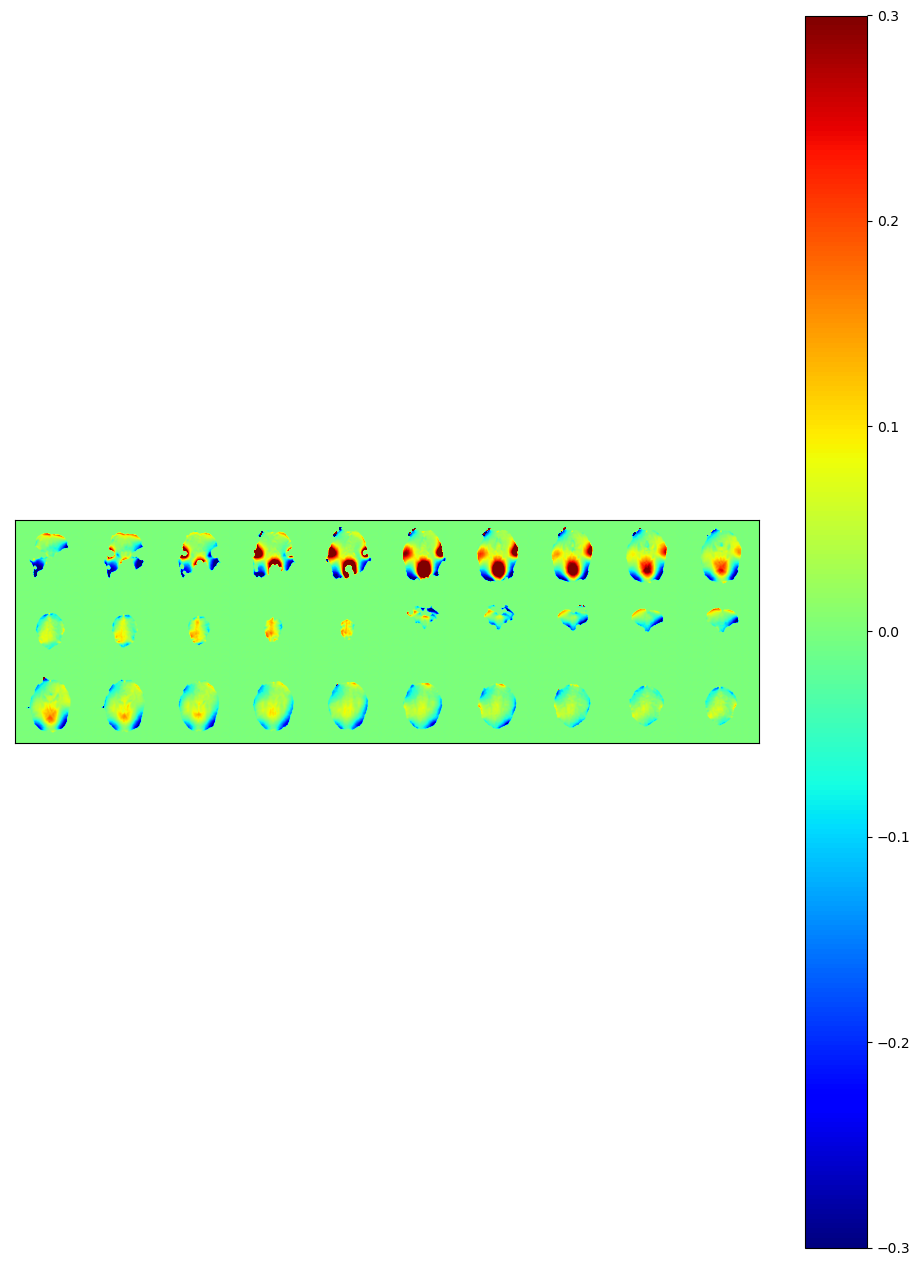

In [28]:
figure(figsize=(12,16))
cjlib.mmontageNEW(delta_freq_map[0]/298., (3,10))
jet()
clim(-0.3,0.3)
colorbar()


(-0.5, 191.5, 191.5, -0.5)

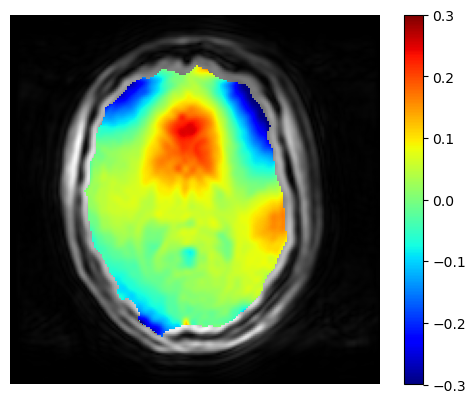

In [29]:
%matplotlib inline
tagSlice=29
# fig,ax0 = plt.subplots(figsize=(5,4),dpi=300)
imshow(cestData_cov_sort[0,0,tagSlice])
gray()
plt.axis('off')

maskedRoi = ma.masked_array(delta_freq_map[0,tagSlice]/298, mask=(mask_slices[tagSlice]==0))
im = imshow(maskedRoi)
jet()
clim(-0.3,0.3)
colorbar()
axis('off')


In [30]:
# B0 correction and normalization
allS0 = np.where(cestFreq_sort >= 100)[0]
cestDataCorrected = zeros((cestData_cov_sort_new.shape[0],cestData_cov_sort_new.shape[1]-len(allS0),cestData_cov_sort_new.shape[2],cestData_cov_sort_new.shape[-2],cestData_cov_sort_new.shape[-1]))

w=cestFreq_sort*298

for ii in range(cestData_cov_sort_new.shape[0]):
    for jj in range(cestData_cov_sort_new.shape[2]):
        MI_rare = cestData_cov_sort_new[ii,:,jj]
        MI_rare=MI_rare.transpose(1,2,0)
        b0map=delta_freq_map[ii,jj]
        Thmask=mask_slices[jj]
        dataTemp,cestFreq_use = Zprocess_S_func(MI_rare,w,b0map,Thmask)
        dataTemp = dataTemp.transpose(2,0,1)
        cestDataCorrected[ii,:,jj] = dataTemp
    
    

/tmp/ipykernel_2682423/1520299878.py:32: RuntimeWarning: invalid value encountered in true_divide
  Mz[:,:,k] = temp/M0


In [32]:
# import scipy.io
# save_dir = '../Downloads/'
# scipy.io.savemat(save_dir + "cestDataCorrected_old.mat", {'data':cestDataCorrected})

# ROI

(-0.5, 191.5, 191.5, -0.5)

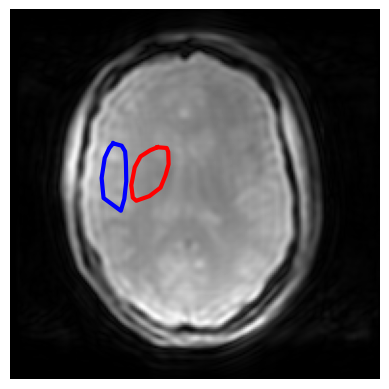

In [33]:
tagB1 = 0
tagSlice = 0

roi = [(76.1, 71.1), (72.30000000000001, 72.69999999999999), (67.30000000000001, 75.89999999999999), (64.30000000000001, 81.5), (62.49999999999999, 90.89999999999999), (63.300000000000004, 97.3), (65.1, 98.89999999999999), (71.9, 96.5), (77.69999999999999, 92.1), (80.30000000000001, 85.69999999999999), (81.9, 79.89999999999999), (81.69999999999999, 73.5), (80.9, 71.5)]
roi2 = [(53.1, 69.1), (51.1, 71.5), (48.699999999999996, 76.69999999999999), (47.1, 87.1), (48.1, 97.5), (57.1, 104.1), (58.9, 97.89999999999999), (59.9, 88.69999999999999), (59.699999999999996, 78.5), (59.300000000000004, 73.3), (57.49999999999999, 70.3)]
# roi2 = [(x[0]-1, x[1]-1) for x in roi2]
# roi = [(x[0]-1, x[1]-1) for x in roi]

mask_roi= roipolyny_2(cestDataCorrected[tagB1,:,tagSlice], roi)
mask_roi2= roipolyny_2(cestDataCorrected[tagB1,:,tagSlice], roi2)

figure()

imshow(cestData_cov_sort[tagB1,:,tagSlice][0])
gray()
# plt.axis('off')

# maskedRoi = ma.masked_array(cestDataCorrected[tagB1,:,tagSlice][0], mask=(mask_roi==0))
# imshow(maskedRoi)
# jet()

XY = roi
XY=np.array(XY)
XY = np.concatenate ((XY, [XY[0,:]]), axis=0 )
plot(XY.transpose()[0], XY.transpose()[1], 'r-', linewidth = 3)
figure(1).canvas.draw()

XY = roi2
XY=np.array(XY)
XY = np.concatenate ((XY, [XY[0,:]]), axis=0 )
plot(XY.transpose()[0], XY.transpose()[1], 'b-', linewidth = 3)
figure(1).canvas.draw()

axis('off')
# imshow(mask)

In [36]:
data_pulsePowerDependence_masked=zeros((cestDataCorrected.shape[0],2,cestDataCorrected.shape[1],cestDataCorrected.shape[2]))

for ii in range(cestDataCorrected.shape[0]):
    for jj in range(cestDataCorrected.shape[2]):
        data_pulsePowerDependence_masked[ii,0,:,jj] = nylib2.applyMask(cestDataCorrected[ii,:,jj], mask_roi)
        data_pulsePowerDependence_masked[ii,1,:,jj] = nylib2.applyMask(cestDataCorrected[ii,:,jj], mask_roi2)


Text(0, 0.5, 'S/S$_0$')

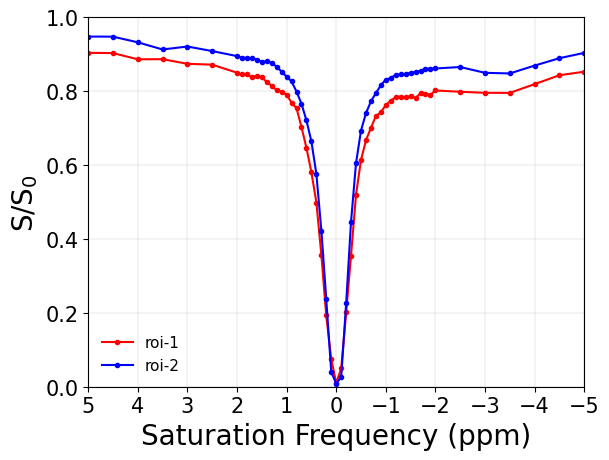

In [37]:
tagB1 = 0
tagSlice = 0

# figure(figsize=(5,4),dpi=300)

plot(cestFreq_use, data_pulsePowerDependence_masked[0,0,:,tagSlice],'r.-',label='roi-1')
plot(cestFreq_use, data_pulsePowerDependence_masked[tagB1,1,:,tagSlice],'b.-',label='roi-2')

grid('on',linewidth=0.2)
ylim(0., 1.)
xlim(5,-5)
tick_params(labelsize=15)
legend(loc='lower left',frameon=False, fontsize=11)
xlabel('Saturation Frequency (ppm)',fontsize=20)
xticks([5,4,3,2,1,0,-1,-2,-3,-4,-5])
ylabel('S/S$_0$',fontsize=20)

# Multi-pool fitting

We perform the lorentzian - based fitting to generate true values to be provided to the model for training

The 4 pools used here are water, amide, noe and mt respectively

We quantify three parameters .i.e amplitude, width and offset of each pool using a lorentzian line-shape

In [16]:
import Lorentzian_Fitting_4pool
#amplitude,width,offset
#water,amide,noe,mt
p = (1,
     0.9,1.4,0,#water
     0.025,0.5,3.5,#amide
     0.02,3,-3.5,#noe
     0.1,25,0.1)#mt
lower_bounds =(0,
               0.02,0.3,-1,#water
               0,0.4,3,#amide
               0,1,0,
               0,10,-4)
upper_bounds =(1,
               1,10,1,#water
               0.2,3,4,#amide
               1,5,2,#noe
               0.5,100,4)#mt


Voxel by voxel multi-pool fitting labels

In [12]:
#load motion_corrected data
import scipy.io
save_dir ='E:/'

cestDataCorrected_motion_pca = scipy.io.loadmat(save_dir +  'cestDataCorrected_PCA.mat')
cestDataCorrected_motion_pca = cestDataCorrected_motion_pca['data']
cestDataCorrected_motion_pca.shape

(1, 56, 30, 192, 192)

In [37]:
tagSlice = 26
tagB1 = 0

data_use = cestDataCorrected_motion_pca[tagB1,:,tagSlice]

Freq = cestFreq_use
z_spec =[]
p1s = []
parameters_list_voxel = []

for ii in range(mask_slices[tagSlice].shape[0]):
    print (ii)
    for jj in range(mask_slices[tagSlice].shape[1]):

            if (mask_slices[tagSlice,ii, jj] != 0):
                Z_spectrum = data_use[:, ii, jj]
                
                parameters = Lorentzian_Fitting_4pool.multipool_lorentzian(Freq, Z_spectrum,p,4,lower_bounds,upper_bounds)
                dict_param = {'amp_water':parameters[0][1],'width_water':parameters[0][2],'offset_water':parameters[0][3],
                         'amp_amide':parameters[0][4],'width_amide':parameters[0][5],'offset_amide':parameters[0][6],
                         'amp_noe':parameters[0][7],'width_noe':parameters[0][8],'offset_noe':parameters[0][9],
                         'amp_mt':parameters[0][10],'width_mt':parameters[0][11],'offset_mt':parameters[0][12]}
                parameters_list_voxel.append(dict_param)
                p1s.append(parameters[1])
                z_spec.append(Z_spectrum)
fit_p = pd.DataFrame(parameters_list_voxel)
fit_p.to_csv('../Downloads/fitted_params_pca_slice_28.csv',index=False)

p = pd.DataFrame(p1s)
p.to_csv('../Downloads/fits_pca_slice_28.csv',index=False)

z = pd.DataFrame(z_spec)
z.to_csv('../Downloads/z_spectra_pca_slice_28.csv',index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [35]:
pd.DataFrame(parameters_list_voxel)

,amp_water,width_water,offset_water,amp_amide,width_amide,offset_amide,amp_noe,width_noe,offset_noe,amp_mt,width_mt,offset_mt
0,0.888552,0.485316,0.009752,0.054030,0.400000,3.376746,0.050768,1.000121,-0.357258,0.076444,10.000000,-3.033150
1,0.832788,0.463040,0.017233,0.066043,0.400000,3.304539,0.079422,1.000000,-0.306511,0.051279,10.000000,-3.573811
2,0.820686,0.483785,0.011476,0.057297,0.400000,3.266806,0.064615,1.000000,-0.325021,0.032882,10.000004,-3.227466
3,0.898027,0.652744,0.000770,0.050500,0.565180,3.282294,0.048228,1.384115,-3.299755,0.087625,12.884680,-1.062039
4,0.918089,0.594413,0.001977,0.076986,0.400000,3.363439,0.077273,1.700529,-3.318378,0.088956,10.000000,-0.903811
...,...,...,...,...,...,...,...,...,...,...,...,...
12665,0.858538,1.002455,0.003942,0.018530,0.400000,3.711658,0.057088,4.916286,-3.079317,0.033279,10.000001,3.999999
12666,0.856551,0.999174,0.004438,0.010299,0.400000,3.590086,0.061007,4.641746,-3.094552,0.038412,10.000004,4.000000
12667,0.847711,0.986237,0.002905,0.009605,0.401506,3.540734,0.063943,3.921027,-3.153241,0.041340,10.059297,3.733556
12668,0.827085,0.973393,0.001302,0.009061,0.400000,3.502890,0.070700,3.232905,-3.229436,0.045509,11.759794,3.453836


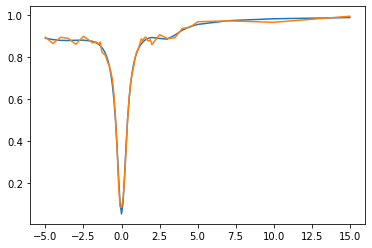

In [66]:
#demonstrate fitting
plot(cestFreq_use, p1s[5])
plot(cestFreq_use, z_spec[5])

# Loading and showing some of the predictions for a few slices

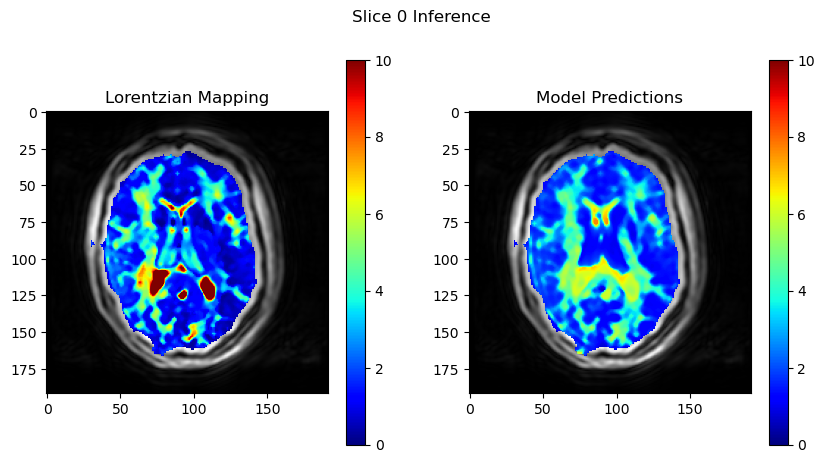

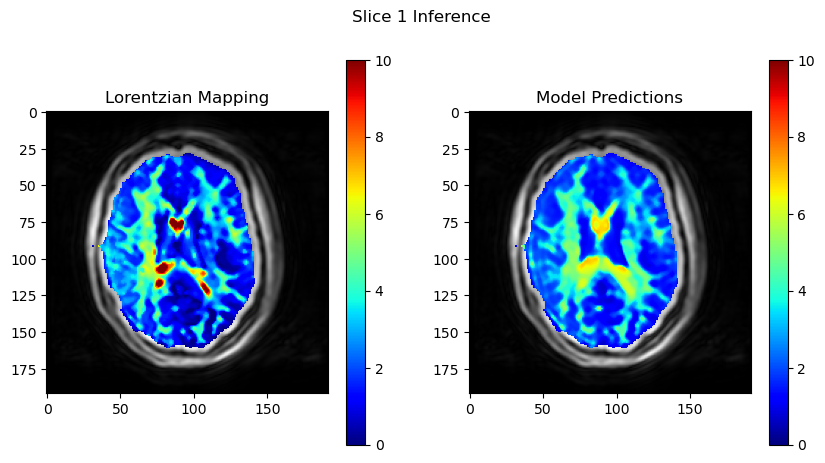

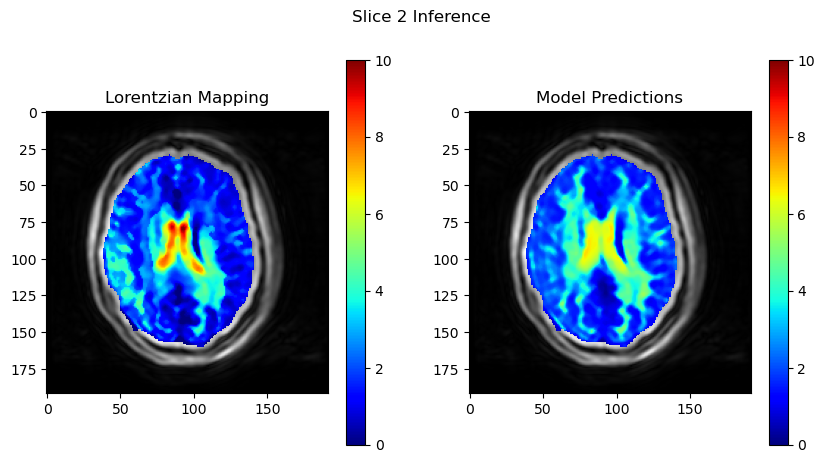

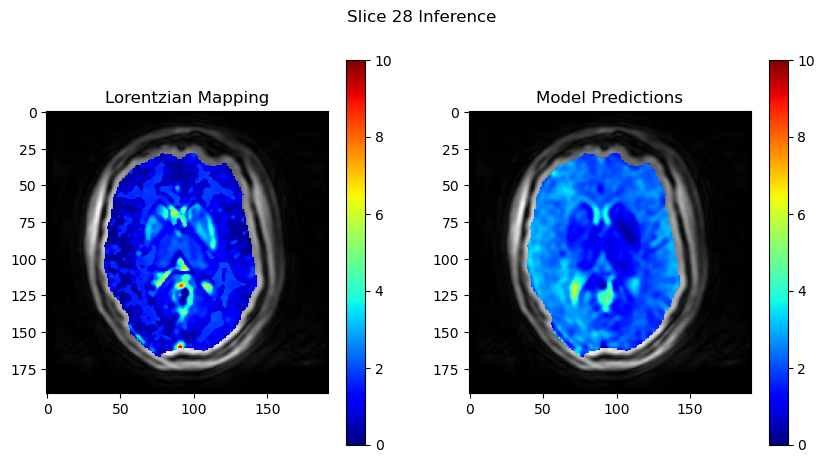

In [179]:
import pandas as pd
import scipy.io
for k in [0,1,2,28]:
    slice_no = k
    save_dir = '/mnt/yadav_lab_backup/vdsouza1/Lorentzian_data_preds/'

    trainingDataIndex = pd.read_csv(save_dir +  'fitted_params_pca_slice_{}.csv'.format(slice_no))
    predDataIndex = pd.read_csv(save_dir +  'Predictions/slice_{}.csv'.format(slice_no))

    from scipy import ndimage
    tagSlice = slice_no
    CESTmap = np.zeros((cestData_cov_sort.shape[3],cestData_cov_sort.shape[4]))
    CEST_pred_map = np.zeros((cestData_cov_sort.shape[3],cestData_cov_sort.shape[4]))
    CEST_apt_data = trainingDataIndex.iloc[:,3]
    CEST_apt_pred = predDataIndex.iloc[:,0]
    i=0
    for ii in range(mask_slices[tagSlice].shape[0]):
        for jj in range(mask_slices[tagSlice].shape[1]):
                if (mask_slices[tagSlice,ii, jj] != 0):
                    CESTmap[ii,jj] = CEST_apt_data[i]
                    CEST_pred_map[ii,jj] = CEST_apt_pred[i]

                    i+=1
    CESTmap = ndimage.median_filter(CESTmap, 3)
    CEST_pred_map = ndimage.median_filter(CEST_pred_map, 3)

    maskedRoi1 = ma.masked_array(CESTmap*100, mask=(mask_slices[tagSlice]==0))

    maskedRoi2 = ma.masked_array(CEST_pred_map*100, mask=(mask_slices[tagSlice]==0))

    fig, ax = plt.subplots(1,2,figsize=(10,5))
    i = [0,1]
    for i, ax in zip(i, ax.ravel()):
        if i==0:
            image = maskedRoi1
        elif i==1:
            image = maskedRoi2

        im = ax.imshow(cestData_cov_sort[0,0,tagSlice], cmap='gray')
        im = ax.imshow(image,vmin = 0, vmax = 10)
        if i ==0:
            ax.set_title('Lorentzian Mapping')
        elif i==1:
            ax.set_title('Model Predictions')

        fig.colorbar(im, ax=ax,pad=0.05)
    plt.suptitle("Slice {} Inference".format(slice_no))

